# Поиск сотрудников для сокращения

Цель проекта - выделить группу сотрудников для сокращения. Для оценки использовались показатели производительности и качества работы. Для анализа была использована [база данных](https://www.kaggle.com/rhuebner/human-resources-data-set/home#production_staff.csv) с сайта Kaggle. Компания и данные о сотрудниках вымышленные. 

Для достижения цели проекта была произведена чистка и визуализация данных, а также был использован алгоритм машинного обучения KMeans Clustering. Сначала все сотрудники были условно разделены на четыре группы на основании размера заработной платы и производительности. Затем были изучены показатели работы сотрудников в каждой группу с использованием графиков и диаграм. Далее была проведена обработка данных при помощи алгоритма.

В результате были выделены потенциальные сотрудники для сокращения, представленные в виде списка.

## Изучение данных

In [1]:
# Импорт необходимых библиотек
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(palette='deep') 
sns.set_style("dark")
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# Чтение данных и сохранение в переменной
staff = pd.read_csv('production_staff.csv')

# Отображение первых пяти строчек
staff.head()

,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,"Albert, Michael",White,8/1/2011,NaN,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
1,"Bozzi, Charles",Asian,9/30/2013,8/7/2014,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
2,"Butler, Webster L",White,1/28/2016,NaN,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
3,"Dunn, Amy",White,9/18/2014,NaN,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
4,"Gray, Elijiah",White,6/2/2015,NaN,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0


База данных включает колонки:
- Employee Name - Имя сотрудника;
- Race Desc - Раса;
- Date of Hire - Дата найма;
- TermDate - Дата увольнения;
- Reason for Term - Причина увольнения;
- Employment Status - Статус занятости;
- Department - Департамент;
- Position - Должность;
- Pay - Зарплата;
- Manager Name - Имя менеджера;
- Performance Score - Оценка выполнения работы;
- Abutments/Hour Wk 1 - Производительность за первую неделю;
- Abutments/Hour Wk 2 - Производительность за вторую неделю;
- Daily Error Rate - Количество ошибок в день;
- 90-day Complaints - Количество жалоб за последние 90 дней;

Проанализируем значения в каждой колонке. Первые шесть колонок не будут использованы по следующим причинам:
- Employee Name - идентификатор сотрудника;
- Race Desc - модель не должна принимать решение на основе расы;
- Date of Hire - данная переменная может влиять на решение о увольнении сотрудника, однако в базе отсутствуют данные о дате рождения или общем трудовом стаже. Поэтому мы не можем ее использовать;
- TermDate, Reason for Term, Employment Status  - модель не должна "знать" уволен человек или нет;

In [2]:
for col in staff.columns[6:]:
    print(staff[col].value_counts(dropna=False).head(10))

Production           209
NaN                   47
Name: Department, dtype: int64
Production Technician I     137
Production Technician II     58
NaN                          47
Production Manager           14
Name: Position, dtype: int64
NaN         47
 $22.00     25
 $20.00     16
 $24.00     15
 $21.00     15
 $16.00     13
 $15.00     13
 $17.00     12
 $19.00     11
 $23.00     10
Name: Pay, dtype: int64
NaN               47
Michael Albert    23
Elijiah Gray      23
Kissy Sullivan    22
Kelley Spirea     22
Ketsia Liebig     21
Amy Dunn          21
Webster Butler    21
David Stanley     21
Brannon Miller    21
Name: Manager Name, dtype: int64
Fully Meets                 122
NaN                          47
N/A- too early to review     25
Exceeds                      22
90-day meets                 18
Needs Improvement            11
PIP                           7
Exceptional                   4
Name: Performance Score, dtype: int64
NaN      48
 12.0    23
 9.0     23
 5.0     19
 6.

Колонка Department также будет удалена, потому что она содержит только одно значение.

In [3]:
# Удаление колонок
columns_to_drop = ['Race Desc', 'Date of Hire', 'TermDate', 'Reason for Term', 'Employment Status', 'Department']
staff = staff.drop(columns_to_drop, axis=1)

## Чистка данных

После ознакомления с базой нам необходимо подготовить данные для дальнейшего анализа. Для этого мы должны:
- удалить или заменить отсутствующие значения;
- отформатировать данные, представленные в форме, не подходящей для анализа;

In [4]:
# Поиск отсутствующих значений
staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 9 columns):
Employee Name          209 non-null object
Position               209 non-null object
Pay                    209 non-null object
Manager Name           209 non-null object
Performance Score      209 non-null object
Abutments/Hour Wk 1    208 non-null float64
Abutments/Hour Wk 2    208 non-null float64
Daily Error Rate       208 non-null float64
90-day Complaints      208 non-null float64
dtypes: float64(4), object(5)
memory usage: 18.1+ KB


В каждой колонке есть отсутствующие значения. Более того, в каждой колонке их не более 47-48. Предположим, что в этих рядах значения полностью отсутствуют. Для проверки выведем значения на экран.

In [5]:
staff[staff['Employee Name'].isnull()]

,Employee Name,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Наше предположение подтвердилось, ряды будут удалены из базы. 

In [6]:
# Удаление рядом без данных и повторная проверка отсутствующих значений
staff = staff.dropna(how='any')
staff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 0 to 207
Data columns (total 9 columns):
Employee Name          208 non-null object
Position               208 non-null object
Pay                    208 non-null object
Manager Name           208 non-null object
Performance Score      208 non-null object
Abutments/Hour Wk 1    208 non-null float64
Abutments/Hour Wk 2    208 non-null float64
Daily Error Rate       208 non-null float64
90-day Complaints      208 non-null float64
dtypes: float64(4), object(5)
memory usage: 16.2+ KB


После удаления осталось 208 рядов без отсутствующих значений. Проанализируем данные в оставшихся.

In [7]:
staff.head()

,Employee Name,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,"Albert, Michael",Production Manager,$54.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
1,"Bozzi, Charles",Production Manager,$50.50,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
2,"Butler, Webster L",Production Manager,$55.00,Elisa Bramante,Exceeds,0.0,0.0,0.0,0.0
3,"Dunn, Amy",Production Manager,$51.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0
4,"Gray, Elijiah",Production Manager,$54.00,Elisa Bramante,Fully Meets,0.0,0.0,0.0,0.0


Нам необходимо отформатировать значения в колонках:
- Position - убрать ряды со значением "Production Manager", так как для них не производилась оценка производительности и качества работы. Также необходимо заменить название позиций ("Production Technician I" и "Production Technician II") на 0 и 1 для того, чтобы модель могла работать с ними;
- Pay - убрать знак доллара перед значение и перевести в цифровой формат;
- Performance Score - перекодировать значения из текстовых в цифровые по следующей схеме:
    - Exceptional(Значительно превзошел ожидания) - 5
    - Exceeds (Превзошел ожидания) - 4
    - Fully Meets (Ожидаемая производительность) - 3
    - 90-day meets (Производительность ниже ожидаемого) - 2
    - Needs Improvement (Требуются улучшения) - 1
    - N/A- too early to (Неприменимо, слишком рано оценивать) - удалить ряды с данным значением
    - PIP (Сотрудник на этапе постановки целей) - удалить ряды с данным значением

In [8]:
# Удаление рядов со значением "Production Manager"
staff = staff[staff['Position'] != 'Production Manager']

# Замена названий позиций на 0 и 1
staff['Position'] = staff['Position'].apply(lambda x: 0 if x == 'Production Technician I' else 1)

# Перевод значений в колонке Pay в цифровой формат
staff['Pay'] = staff['Pay'].str.strip().apply(lambda x: x[1:]).astype(float)

# Удаление рядов со значениями 'N/A- too early to  review' and 'PIP'
staff = staff[(staff['Performance Score'] != 'N/A- too early to review') &
              (staff['Performance Score'] != 'PIP')]

# Замена текстовых обозначений на цифровые
mapping = {'Exceptional': 5,
           'Exceeds': 4,
           'Fully Meets': 3,
           '90-day meets': 2,
           'Needs Improvement': 1}
staff['Performance Score'] = staff['Performance Score'].map(mapping)

print(staff.shape[0])
print(staff['Position'].value_counts())
print(staff['Pay'].value_counts().head())
print(staff['Performance Score'].value_counts())

162
0    116
1     46
Name: Position, dtype: int64
22.0    21
21.0    15
24.0    13
15.0    12
20.0    11
Name: Pay, dtype: int64
3    111
4     20
2     18
1      9
5      4
Name: Performance Score, dtype: int64


После чисти данных осталось 162 ряда, из которых нам необходимо выбрать сотрудников для увольнения. Предположим, что нам было необходимо сократить штат на 10%. Так как изначальное количество было 208, то нам надо сократить 21 человека или приблизительно 13% из оставшихся. 

Перед тем как принять решение о сокращении мы должны понять общую картину производительности и качества работы, и визуализировать показатели.

## Визуализация данных


### Распределение заработных плат

Text(0.5,1.05,'Процентное распределение сотрудников в зависимости от заработной платы')

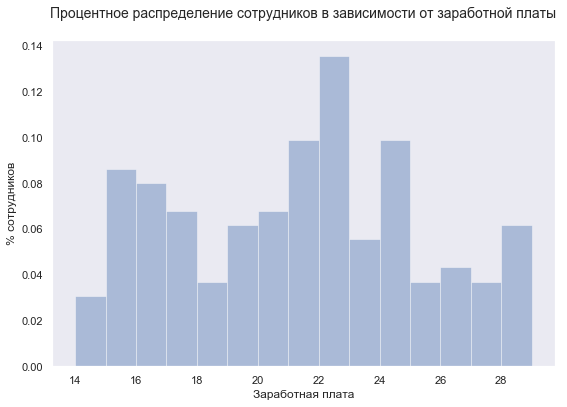

In [9]:
fig = plt.figure(figsize=(9, 6))
sns.distplot(staff['Pay'], bins=15, kde=False, norm_hist=True)
plt.xlabel('Заработная плата', fontsize=12)
plt.ylabel('% сотрудников', fontsize=12)
plt.title('Процентное распределение сотрудников в зависимости от заработной платы', y=1.05, fontsize=14)

Наблюдения:
- большинство сотрудников получают зарплату от 19 до 25 долларов;
- значительная часть сотрудников получает зарплату от 15 до 18 долларов;
- меньшая часть сотрудников получает зарплату более 25 долларов;

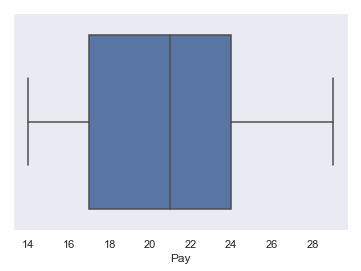

In [10]:
# Альтернативный график распределение заработных плат. На нем можно отследить сотрудников,
# зарплата которых выше рыночной. В данном случае таких сотрудников нет.
sns.boxplot(staff['Pay'])

### Количество сотрудников на разных должностях

Text(0.5,1.05,'Процентное соотношение сотрудников на разных должностях')

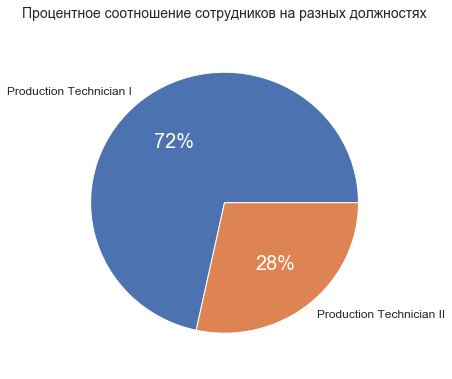

In [11]:
data = staff['Position'].value_counts(normalize=True)
fig = plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(data, labels=["Production Technician I", "Production Technician II"],
                                    autopct='%.f%%', colors=sns.color_palette('deep').as_hex())
for item in texts: item.set_fontsize(12)
for item in autotexts:
    item.set_fontsize(20)
    item.set_color('white')
plt.title('Процентное соотношение сотрудников на разных должностях', y=1.05, fontsize=14)

### Взаимосвязь заработной платы и производительности

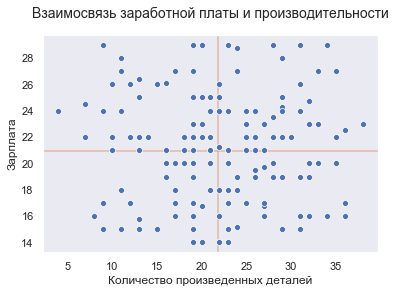

In [12]:
staff['abt_hr_tot'] = staff['Abutments/Hour Wk 1'] + staff['Abutments/Hour Wk 2']
sns.scatterplot(x='abt_hr_tot', y='Pay', data=staff, zorder=2)
plt.title('Взаимосвязь заработной платы и производительности', y=1.05, fontsize=14)
plt.xlabel('Количество произведенных деталей', fontsize=12)
plt.ylabel('Зарплата', fontsize=12)
plt.axhline(staff['Pay'].mean(), color='#dd8452', zorder=1, alpha=0.5)
plt.axvline(staff['abt_hr_tot'].mean(), color='#dd8452', zorder=1, alpha=0.5)

Мы видим, что точки на графике расположены хаотично, зависимость между заработной платой и производительностью отсутствует. Мы можем условно разделить всех работников на четыре категории:
1) Низкая зарплата и низкая производительность (левый нижний угол);
2) Низкая зарплата и высокая производительность (правый нижниу угол);
3) Высокая зарплата и низкая производительность (верхний левый угол);
4) Высокая зарплата и высокая производительность (правый верхний угол;

На основе этого графика мы можем выделить группу сотрудников с высокой зарплатой и низкой производительностью. Сокращение этих сотрудников будет наиболее выгодным. Для дальнейшей визуалиции добавим в базу данных колонку, которая будет идентифицировать группу каждого сотрудника.

In [13]:
# Добавление колонки
def group_staff(row):
    avg_sal = staff['Pay'].mean()
    avg_abt = staff['abt_hr_tot'].mean()
    if row['Pay'] < avg_sal and row['abt_hr_tot'] < avg_abt:
        return 'низкая зп/низкая пр'
    elif row['Pay'] < avg_sal and row['abt_hr_tot'] >= avg_abt:
        return 'низкая зп/высокая пр'
    elif row['Pay'] >= avg_sal and row['abt_hr_tot'] < avg_abt:
        return 'высокая зп/низкая пр'
    else:
        return 'высокая зп/высокая пр'
staff['sal_vs_pr'] = staff.apply(group_staff, axis=1)
# Выводит на экран количество значений каждого типа
staff['sal_vs_pr'].value_counts()

высокая зп/низкая пр     47
высокая зп/высокая пр    45
низкая зп/высокая пр     38
низкая зп/низкая пр      32
Name: sal_vs_pr, dtype: int64

Рассмотрим распределение количества ошибок в день, количества жалоб и оценок выполнения работы в каждой группе.

### Анализ количества ошибок, количества жалоб и оценок выполнения работы

Сначала создадим функцию для быстрой визуализации данных.

In [14]:
# Определение функции
def for_bar(df, metric):
    data = (df[['sal_vs_pr', metric]]
            # Группировка датасета по колонке 'sal_vs_pr' и метрике,
            # Выбор колонки метрики из сгруппированного датасета
            .groupby(['sal_vs_pr', metric])[metric]
            # Подсчет количества оценок в каждой категории
            # Переустановка индекса
            .agg('count')).reset_index(name=metric + ' count') # Нужно новое имя, так как совпадает с одним из
                                                               # индексов
    # Находит процент каждого значения метрики в одной подгруппе
    data[metric + ' prc'] = np.round((data[metric + ' count'] /
                                     # Находит сумму для каждой подгруппы
                                     data.groupby('sal_vs_pr')
                                    .transform(sum)[metric+' count']) * 100)
    # Выводит график на экран
    plt.figure(figsize=(9, 6))
    sns.barplot(x='sal_vs_pr', y=metric + ' prc', hue=metric, data=data)
    plt.xticks(rotation=45)
    plt.xlabel('', fontsize=12)
    plt.ylabel('Процент сотрудников', fontsize=12)
    plt.legend(loc='upper right')
    plt.title('Метрика: {}'.format(metric))

Теперь мы можем сравнить показатели разных метрик внутри каждой группы. Начнем с метрики "количество ошибок" (Daily Error Rate). 

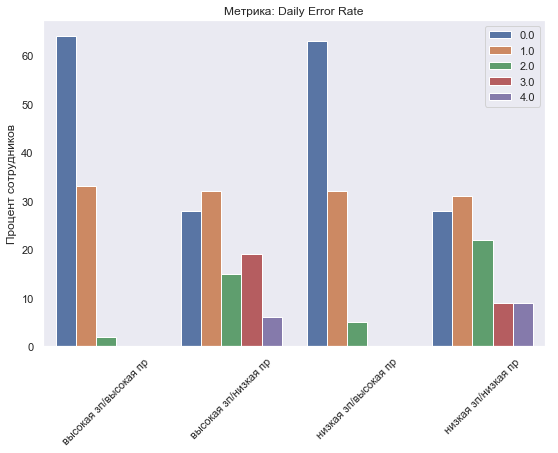

In [15]:
for_bar(staff, 'Daily Error Rate')

Наблюдения:
- процент сотрудников, которые допускают одну ошибку в день примерно одинаковый во всех группах;
- процент сотрудников, которые не допускают ошибок значительно больше в группах высокая зп/высокая пр и низкая зп/высокая пр;
- процент сотрудников, которые допускают 2 и более ошибок значительно больше в группах высокая зп/низкая пр и низкая зп/низкая пр;

Вывод: на основании данной метрики мы можем подтвердить предположение о том, сокращение сотрудников из группы высокая зп/низкая пр будет наиболее выгодным, так как они допускают больше ошибок, а также требуют больших затрат чем сотрудники из группы низкая зп/низкая пр. 

Далее рассмотрим метрику "количество жалоб на сотрудников в течение 90 дней" (90-day Complaints).

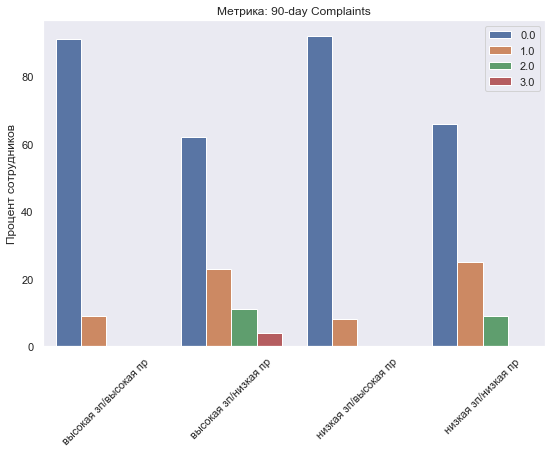

In [16]:
for_bar(staff, '90-day Complaints')

Наблюдения:
- процент сотрудников без жалоб больше в группах высокая зп/высокая пр и низкая зп/высокая пр;
- на сотрудников в остальных группах чаще поступают жалобы, причем количество жалоб на сотрудников из группы высокая зп/низкая пр самое высокое. 
- Вывод: сокращение сотрудников из группы высокая зп/низкая будет самым отпимальным.

Следующая метрика - "оценка выполнения работы" (Performance Score).

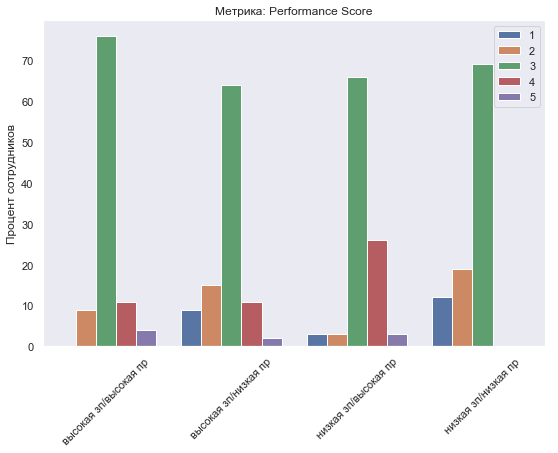

In [17]:
for_bar(staff, 'Performance Score')

Наблюдения:
- распределине оценок примерно одинаковое в первых двух группах, однако во второй группе выше количество оценок 1 и 2;
- средняя оценка выше всего в группе низкая зп/высокая пр, и ниже всего в группе низкая зп/низкая пр;

Вывод: для увольнения следует рассматривать сотрудников из групп высокая зп/низкая пр и низкая зп/низкая пр. 

### Вывод на основовании визуализации данных
Для сокращения рекомендованно рассмотреть сотрудников из группы высокая зп/низкая пр. 

## Кластерный анализ

Для подтверждения результатов визуализации проведем кластерный анализ с использование алгоритма машинного обучения. Перед использованием необходимо выбрать и подготовить колонки для анализа. 

In [18]:
staff.head()

,Employee Name,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints,abt_hr_tot,sal_vs_pr
14,"Adinolfi, Wilson K",0,20.0,Michael Albert,4,15.0,17.0,0.0,0.0,32.0,низкая зп/высокая пр
15,"Alagbe,Trina",0,21.0,Elijiah Gray,3,8.0,10.0,1.0,0.0,18.0,высокая зп/низкая пр
17,"Anderson, Linda",0,23.0,Amy Dunn,5,19.0,19.0,0.0,0.0,38.0,высокая зп/высокая пр
19,"Bachiochi, Linda",0,22.0,Brannon Miller,3,10.0,10.0,0.0,0.0,20.0,высокая зп/низкая пр
21,"Barbara, Thomas",0,22.0,Kissy Sullivan,2,5.0,8.0,0.0,0.0,13.0,высокая зп/низкая пр


Так как алгоритм может работать только с цифровыми значениями, мы используем следующие колонки:
- Pay - Зарплата;
- Performance Score - Оценка выполнения работы;
- Daily Error Rate - Количество ошибок в день;
- 90-day Complaints - Количество жалоб за последние 90 дней;
- abt_hr_tot - Количество произведенных деталей за две недели;

### Трансформация данных
Для того, чтобы получить последовательные результаты, колонки должны следовать одной и той же логике. На данный момент:
- Pay - чем меньше, тем лучше (меньше затрат не персонал);
- Performance Score - чем выше, тем лучше;
- Daily Error Rate - чем меньше, тем лучше;
- 90-day Complaints - чем меньше, тем лучше;
- abt_hr_tot - чем выше, тем лучше;

Выберем логику "чем меньше, тем лучше". Нам необходимо трансформировать колонки Performance Score и abt_hr_tot, так как они следуют обратной логике. Для этого возьмем максимальное значение в каждой колонке и вычтем из него все остальные значения. 

In [19]:
# Трансформация колонок
def reverse_logic(data, col):
    data[col + '_rev'] = np.abs(data[col] - data[col].max())
    return data
for col in ['Performance Score', 'abt_hr_tot']:
    reverse_logic(staff, col)
    
# Выбор колонок для кластерного анализа
cluster_cols = ['Employee Name', 'sal_vs_pr', 'Pay', 'Daily Error Rate', '90-day Complaints',
                'Performance Score_rev', 'abt_hr_tot', 'abt_hr_tot_rev']
cluster_staff = staff.copy()[cluster_cols]
cluster_staff.describe()

,Pay,Daily Error Rate,90-day Complaints,Performance Score_rev,abt_hr_tot,abt_hr_tot_rev
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,20.942593,0.901235,0.296296,2.049383,21.858025,16.141975
std,4.048681,1.093231,0.619446,0.746024,7.379565,7.379565
min,14.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,17.000000,0.000000,0.000000,2.000000,17.000000,11.000000
50%,21.000000,1.000000,0.000000,2.000000,22.000000,16.000000
75%,24.000000,1.000000,0.000000,2.000000,27.000000,21.000000
max,29.000000,4.000000,3.000000,4.000000,38.000000,34.000000


Минимальные и максимальные значения в колонках достаточно сильно различаются. Для того, чтобы данные из колонки с большими значениями не искажали общую картину проведем нормализацию данных.

In [20]:
# Нормализация данных
norm_cols =  ['Pay', 'Daily Error Rate', '90-day Complaints', 'Performance Score_rev', 'abt_hr_tot_rev'] 
scaler = MinMaxScaler()
scaler.fit(cluster_staff[norm_cols])
cluster_staff[norm_cols] = scaler.transform(cluster_staff[norm_cols])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Теперь мы можем использовать эти данные для алгоритма и визуализации кластеров.

### Визуализация кластеров

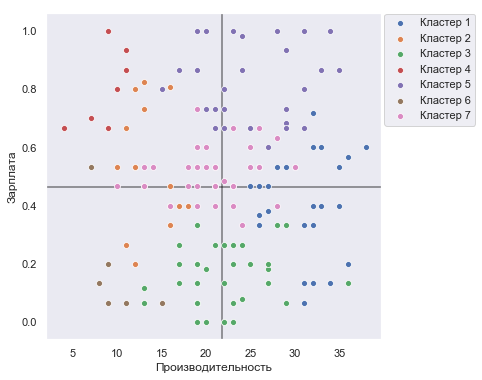

In [21]:
def vis_clusters(data, norm_cols):
    data = data.copy()
    kmeans = KMeans(n_clusters=7, random_state=1).fit(data[norm_cols])
    data['cluster'] = kmeans.labels_ + 1
    legends = []
    plt.figure(figsize=(6, 6))
    for i in range(1, 8):
        sns.scatterplot(x='abt_hr_tot', y='Pay', data=data[data['cluster'] == i], zorder=2)
        legends.append('Кластер ' + str(i))
    plt.xlabel('Производительность')
    plt.ylabel('Зарплата')
    plt.legend(legends, loc=(1.01, 0.655))
    plt.axhline(data['Pay'].mean(), color='black', zorder=1, alpha=0.5)
    plt.axvline(data['abt_hr_tot'].mean(), color='black', zorder=1, alpha=0.5)
    
    return data

cluster_staff1 = vis_clusters(cluster_staff, norm_cols)

Из графика видно, что набольшая зарплата и наименьшая производительность наблюдается в кластерах 2 и 4. Мы можем вывести на экран список людей из этих кластеров. 

In [22]:
cluster_staff1[['Employee Name', 'sal_vs_pr']][
    (cluster_staff1['cluster'] == 2) |
    (cluster_staff1['cluster'] == 4)].sort_values(by='sal_vs_pr')

,Employee Name,sal_vs_pr
35,"Chivukula, Enola",высокая зп/низкая пр
191,"Nowlan, Kristie",высокая зп/низкая пр
182,"Lunquist, Lisa",высокая зп/низкая пр
180,"Linden, Mathew",высокая зп/низкая пр
172,"Homberger, Adrienne J",высокая зп/низкая пр
166,"Foreman, Tanya",высокая зп/низкая пр
161,"Demita, Carla",высокая зп/низкая пр
159,"Close, Phil",высокая зп/низкая пр
152,"Beak, Kimberly",высокая зп/низкая пр
140,"Tippett, Jeanette",высокая зп/низкая пр


# Результаты

На основе кластерного анализа мы получили следующие результаты:
- список людей для увольнения (24 кандидата);
- первыми рекомендованно сократить людей из категории "высокая зп/низкая пр";
- оставшихся следует выбрать из категории "низкая зп/низкая пр";